# Contemporaneous and lagged causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI class and create high-quality plots of the results.

This tutorial explains the function ``PCMCI.run_pcmciplus``. In contrast to standard ``PCMCI.run_pcmci``, PCMCIplus allows to identify the full, lagged and contemporaneous, causal graph (up to the Markov equivalence class for contemporaneous links) under the standard assumptions of Causal Sufficiency, Faithfulness and the Markov condition. 

PCMCIplus is described here:
J. Runge (2020), Discovering contemporaneous and lagged causal relations in autocorrelated nonlinear time series datasets
https://arxiv.org/abs/2003.03685

See the following paper for theoretical background:
Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

## 1. Structural causal processes with contemporaneous and lagged dependencies

We are interested in reconstructing *time series graphs* that can be used to represent the temporal dependency structure underlying complex dynamical systems. Consider an underlying time-dependent system $\mathbf{X}_t=(X^1_t,\ldots,X^N_t)$ with 

\begin{align} \label{eq:causal_model}
X^j_t &= f_j\left(\mathcal{P}(X^j_t),\,\eta^j_t\right)
\end{align}

where $f_j$ is some arbitrary measurable function with non-trivial dependencies on its arguments and $\eta^j_t$ represents mutually ($i\neq j$) and serially ($t'\neq t$) independent dynamical noise. The nodes in a time series graph represent the variables $X^j_t$ at different lag-times and the set of variables that $X^j_t$ depends on defines the causal parents $\mathcal{P}(X^j_t)\subset \mathbf{X}^-_{t+1}=(\mathbf{X}_{t}, \mathbf{X}_{t-1},\ldots){\setminus} \{ X^j_t\}$. A causal link $X^i_{t-\tau} \to X^j_t$ exists if $X^i_{t-\tau}\in \mathcal{P}(X^j_t)$. For $\tau>0$ we call them lagged links and for $\tau=0$ we call $X^i_{t} \to X^j_t$ a contemporaneous link. Then the variables $X^j_t \in \mathbf{X}_t$  together with their parents $\mathcal{P}(X^j_t)$ represent the time series graph $\mathcal{G}$.

In Tigramite a variant of this process (generalized additive model) can be generated with the function ``pp.structural_causal_process``. Note that, in contrast to ``pp.var_process``, here links have the format ``((i, -tau), coeff, func)`` where ``func`` can be an arbitrary (nonlinear) function provided as a python callable with one argument and coeff is the multiplication factor. That is, ``pp.structural_causal_process`` generates processes of the form

\begin{align}
X^j_t &= \eta^j_t + \sum_{X^i_{t-\tau}\in \mathcal{P}(X^j_t)} c^i_{\tau} f\left(X^i_{t-\tau}\right)
\end{align}

The noise distributions of $\eta^j$ can be specified in ``pp.structural_causal_process``.
Importantly, for $\tau=0$ we can generate contemporaneous, also called instantaneous, causal dependencies. Note that these need to be acyclic, otherwise an Error will be raised. Consider the following example taken from the PCMCIplus description paper:

In [2]:
seed = 7
auto_coeff = 0.95
coeff = 0.4
T = 500
def lin(x): return x

links ={0: [((0, -1), auto_coeff, lin),
            ((1, -1), coeff, lin)
            ],
        1: [((1, -1), auto_coeff, lin), 
            ],
        2: [((2, -1), auto_coeff, lin), 
            ((3, 0), -coeff, lin), 
            ],
        3: [((3, -1), auto_coeff, lin), 
            ((1, -2), coeff, lin), 
            ],
        4: [((4, -1), auto_coeff, lin), 
            ((3, 0), coeff, lin), 
            ],   
        5: [((5, -1), 0.5*auto_coeff, lin), 
            ((6, 0), coeff, lin), 
            ],  
        6: [((6, -1), 0.5*auto_coeff, lin), 
            ((5, -1), -coeff, lin), 
            ],  
        7: [((7, -1), auto_coeff, lin), 
            ((8, 0), -coeff, lin), 
            ],  
        8: [],                                     
        }

# Specify dynamical noise term distributions, here unit variance Gaussians
noises = [np.random.randn for j in links.keys()]
    
data, nonstationarity_indicator = pp.structural_causal_process(
    links=links, T=T, noises=noises, seed=seed)
T, N = data.shape

# Initialize dataframe object, specify variable names
var_names = [r'$X^{%d}$' % j for j in range(N) ]
dataframe = pp.DataFrame(data, var_names=var_names)

The true graph $\mathcal{G}$ here has shape ``(N, N, 2+1)`` since the maximum true time lag is ``tau_max=2``. An entry ``true_graph[i,j,tau]=1`` indicates a causal link $X^i_{t-\tau} \to X^j_t$ and ``true_graph[i,j,tau]=0`` the absence of a causal link. 

In [3]:
true_graph = pp.links_to_graph(links=links)

## 2. PCMCI+: Causal discovery for contemporaneous and lagged dependencies

The goal of PCMCIplus is to reconstruct the graph $\mathcal{G}$. We will see that, even with infinite sample size and all assumptions being fulfilled, this is not always possible and graphs can only be reconstructed up to a Markov equivalence class. 

### General idea

The general idea behind PCMCIplus follows that of the PC algorithm: 

* **Skeleton discovery phase**: Starting from a completely connected graph first a skeleton of adjacencies $X^i_{t-\tau} - X^j_t$ is estimated by identifying which pairs of nodes are conditionally independent for any subset of the other nodes. The adjacency between conditionally independent pairs is removed. The lagged adjacencies in that skeleton are then automatically oriented by time-order. For example, an undirected link $X^i_{t-2} - X^j_t$ can only be oriented as $X^i_{t-2} \to X^j_t$ since causal effects cannot go back in time. 

* **Collider orientation phase**: The contemporaneous adjacencies $X^i_{t} - X^j_t$ are then oriented based on the following collider rule. For an unshielded triple $X^k_{t-\tau} - X^i_t - X^j_t$ with $\tau\geq 0$ (for $\tau>0$ we always have $X^k_{t-\tau} \rightarrow X^i_t$) with no adjacency between $X^k_{t-\tau}$ and $X^j_t$: If $X^i_t$ is *not* part of the conditioning set that makes $X^k_{t-\tau}$ and $X^j_t$ independent, then orient  $X^k_{t-\tau} - X^i_t - X^j_t$ as  $X^k_{t-\tau} \rightarrow X^i_t \leftarrow X^j_t$. This rule is applied to all unshielded triples. There are three options (``contemp_collider_rule={'none', 'majority', 'conservative'}``) to decide whether a middle node $X^i_t$ is *not* part of the separating conditioning set: ``'none'``: In the original PC algorithm the conditions that lead to conditional independence in the skeleton discovery phase are stored (``sepset`` in Tigramite) and then used in the collider phase. Alternatively, all separating conditioning sets are *re-computed* based on the neighbors of $X^k_{t-\tau}$ and $X^j_t$ and collider motifs are oriented based on the ``'majority'`` or ``'conservative'`` rule as discussed in the paper.

* **Rule orientation phase**: Orient further adjacencies such that the graph does not contain cycles (rules R1-R3 in paper).

This algorithm results in a graph containing directed (lagged and contemporaneous) links  $X^i_{t-\tau} \to X^j_t$, but also contemporaneous links  $X^i_{t-\tau} - X^j_t$ that could not be oriented according to the phases above. For example, if the middle node $X^k_t$ in the fully contemporaneous triple $X^i_{t} - X^k_t - X^j_t$ *is* part of the conditioning set that makes $X^i_{t}$ and $X^j_t$ independent, then we cannot distinguish whether the true causal relations are $X^i_{t} \to X^k_t \to X^j_t$ or $X^i_{t} \leftarrow X^k_t \leftarrow X^j_t$ or $X^i_{t} \leftarrow X^k_t \to X^j_t$. These then form the *Markov equivalence class*. Note that triples involving a lagged $X^i_{t-\tau}$ for $\tau>0$ greatly help in orienting links since then only the first motif is possible.

**Order independence**: An important undesirable property of the original PC algorithm is that it depended on the order of the $N$ variables. This can be overcome by employing slightly modified version of the skeleton phase (implemented in Tigramite), the majority or conservative collider rule mentioned above, and by marking all links where orientation rules are conflicting with each other (``conflict_resolution=True``).

### PCMCIplus Algorithm

Compared to the standard PC algorithm adapted to time series, PCMCIplus is based on two central ideas: First, the skeleton phase is conducted separately for lagged and contemporaneous conditioning sets and the lagged phase uses much less tests leading to more power. Secondly, PCMCIplus modifies the conditioning sets for the individual conditional independence tests to make them well-calibrated under autocorrelation and increase detection power by utilizing the momentary conditional independence (MCI) approach. In summary, PCMCIplus estimates time-lagged and contemporaneous causal links by a four-phase algorithm (see detailed pseudo-code in the paper):

1.  **Skeleton discovery phase with lagged conditions** (same as for PCMCI): For each variable $X^j_t$, estimate a *superset* of lagged ($\tau>0$) parents $\widehat{\mathcal{B}}_t^-( X^j_t)$ with the iterative PC1 algorithm, implemented as ``run_pc_stable``.

2.   **Skeleton discovery phase with contemporaneous conditions and *momentary conditional independence* (MCI) tests**: Iterate through subsets $\mathcal{S}\subset \mathbf{X}_t$ of contemporaneous adjacencies and remove adjacencies for all (lagged and contemporaneous) ordered pairs $(X^i_{t-\tau}, X^j_t)$ with $X^j_{t} \in \mathbf{X}_t$ and $X^i_{t-\tau} \in \mathbf{X}_t \cup \widehat{\mathcal{B}}_t^-(X^j_t)$ if the MCI conditional independence holds ($\widehat{\mathcal{B}}_{t-\tau}^-(X^i_{t-{\tau}})$ are the parents of $X^i_{t-\tau}$):

\begin{align}
    X^i_{t-\tau} &~\perp~ X^j_{t} ~|~ \mathcal{S}, \widehat{\mathcal{B}}_t^-(X^j_t), \widehat{\mathcal{B}}_{t-\tau}^-(X^i_{t-{\tau}})
\end{align}

3.   **Collider orientation phase**: Orient contemporaneous links based on unshielded triples. Optionally apply conservative or majority rule (also based on MCI tests).

4.   **Rule orientation phase**: Orient remaining contemporaneous links based on rules R1-R3 in paper.

Phases 2-4 are implemented in ``run_pcalg`` with the parameter ``mode='contemp_conds'``.
The MCI test conditions on the lagged supersets of parents for *both* $X^i_{t-\tau}$ and $X^j_t$, which is the same idea as in PCMCI. The reasoning behind this is discussed in detail in the paper where also the consistency and order independence of PCMCIplus are proven.

In contrast to PCMCI, the relevant output of PCMCIplus is the array ``graph``. Its entries are interpreted as follows (under the standard assumptions of Causal Sufficiency, Faithfulness and the Markov condition):

 * ``graph[i,j,tau]=1`` for ``tau > 0`` denotes a directed, lagged causal link $X^i_{t-\tau} \to X^j_t$

 * ``graph[i,j,0]=1`` and ``graph[j,i,0]=0`` denotes a directed, contemporaneous causal link $X^i_{t} \to X^j_t$

 * ``graph[i,j,0]=1`` and ``graph[j,i,0]=1`` denotes an unoriented, contemporaneous adjacency $X^i_{t} - X^j_t$ indicating that the collider and orientation rules could not be applied (Markov equivalence)
 
 * ``graph[i,j,0]=2`` and ``graph[j,i,0]=2`` denotes a conflicting, contemporaneous adjacency between $X^i_{t}$ and $X^j_t$ indicating that the directionality is undecided due to conflicting orientation rules
 
An example of a conflict is when an adjacency  $X^i_{t} - X^j_t$ is part of two triples and the collider rules applied to one triple suggests  $X^i_{t} \to X^j_t$ while for the other triple it suggests  $X^i_{t} \leftarrow X^j_t$. This can happen due to finite sample effects or violations of the assumptions.

Importantly, ``p_matrix`` and ``val_matrix`` for PCMCIplus quantify the uncertainty and strength, respectively, only for the *adjacencies* in phase 2, but not for the *directionality* of contemporaneous links determined in phases 3 and 4. Note that lagged links are always oriented due to time order.

### Parameters

PCMCIplus can be flexibly combined with any kind of conditional independence test statistic adapted to the kind of data (continuous or discrete) and its assumed dependency types. These are available in ``tigramite.independence_tests``.

The main free parameters of PCMCIplus (in addition to free parameters of the conditional independence tests) are the maximum time delay $\tau_{\max}$ (``tau_max``) and the significance threshold $\alpha_{\rm PC}$ ( ``pc_alpha``). If a list or None is passed for ``pc_alpha``, the significance level is optimized for every graph across the given ``pc_alpha`` values using the score computed in ``cond_ind_test.get_model_selection_criterion()``. The maximum time delay depends on the application and should be chosen according to the maximum causal time lag expected in the complex system. We recommend a rather large choice that includes peaks in the ``run_bivci`` function. Another important parameter is ``contemp_collider_rule``. Only if set to ``majority`` (default) or ``conservative`` and together with ``conflict_resolution=True`` (default), PCMCIplus is fully *order independent* as discussed above, meaning that the order of the N variables in the dataframe does not matter. Last, the default option ``reset_lagged_links=False`` restricts the detection of lagged causal links in phase 2 to the significant adjacencies found in phase 1, given by $\widehat{\mathcal{B}}_t^-( X^j_t)$. For ``reset_lagged_links=True``, *all* lagged links are considered again, which improves detection power for lagged links, but also leads to larger runtimes. Further optional parameters are discussed in the paper or documentation.


## 3. Application example

To conduct a PCMCIplus analysis on the above example process, first we plot the time series. This can be done with the function ``tp.plot_timeseries``:

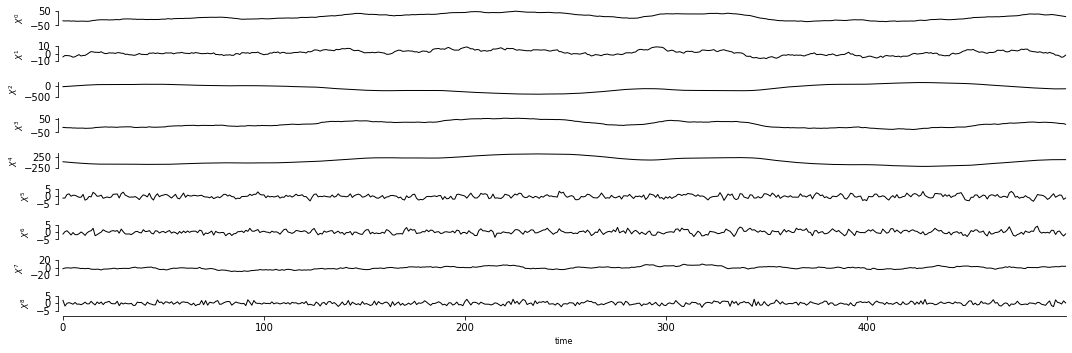

In [4]:
tp.plot_timeseries(dataframe, figsize=(15, 5)); plt.show()

Despite the high autocorrelation, it's stationary and doesn't contain missing values. Check the other tutorials for discussions of non-stationarity and missing values. 

Next, we choose a conditional independence test, here we assume linear dependencies with ``ParCorr`` implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. Then we initialize the ``PCMCI`` class that covers PCMCI as well as PCMCIplus with  ``dataframe`` and ``cond_ind_test``:

In [5]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

Before running PCMCIplus, it's a good idea to run and plot the function ``run_bivci``, which implements a bivariate, lagged conditional independence test (similar to bivariate Granger causality, but lag-specific). This can help to identify which maximal time lag ``tau_max`` to choose. Another option would be to plot ``get_lagged_dependencies``, but large autocorrelation will inflate lag peaks (see https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-13-00159.1) and ``run_bivci`` at least conditions out some part of the autocorrelation.


##
## Running Tigramite BivCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10


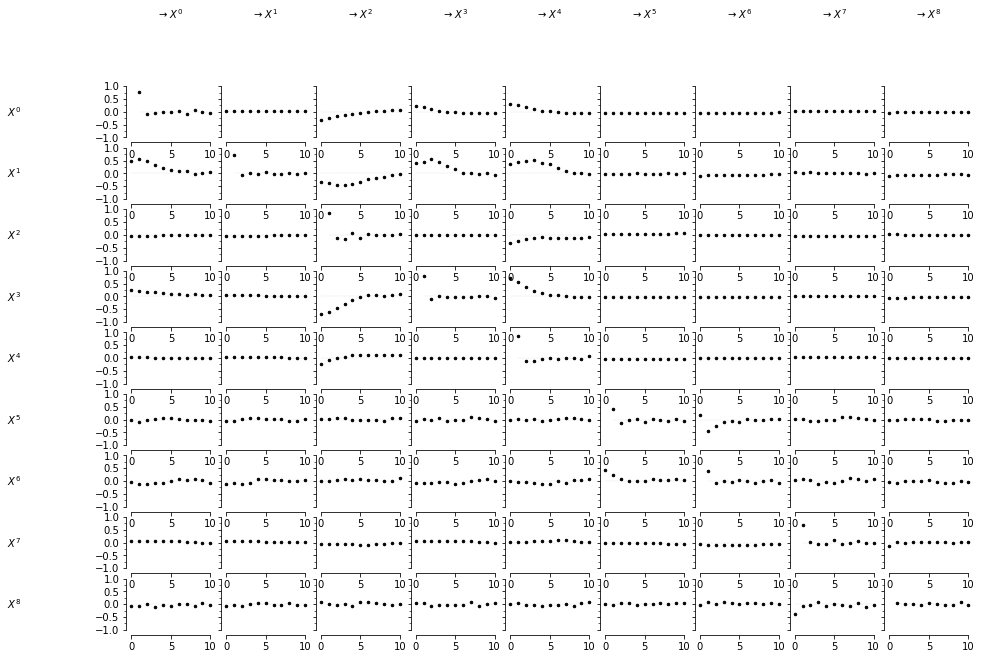

In [6]:
correlations = pcmci.run_bivci(tau_max=10, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                   setup_args={'var_names':var_names, 'figsize':(15, 10),
                                    'x_base':5, 'y_base':.5})

Since the dependencies peak maximally at a lag of around 3, we choose ``tau_max=3`` for PCMCIplus. This choice may, however, stronly depend on expert knowledge of the system. Obviously, for contemporaneous causal discovery, we leave the default ``tau_min=0``. The other main parameter is ``pc_alpha`` which sets the significance level for all tests in PCMCIplus. This is in contrast to PCMCI where ``pc_alpha`` only controls the significance tests in the condition-selection phase, not in the MCI tests. Also for PCMCIplus there is an automatic procedure (like for PCMCI) to choose the optimal value. If a list or None is passed for         ``pc_alpha``, the significance level is optimized for every graph across the given ``pc_alpha`` values using the score computed in ``cond_ind_test.get_model_selection_criterion()``. Since PCMCIplus outputs not a DAG, but an equivalence class of DAGs, first one member is of this class is computed and then the score is computed as the average over all models fits for each variable in [0, ..., N]. The score is the same for all members of the class.

Here we set it to ``pc_alpha=0.01``. In applications a number of different values should be tested and results transparently discussed.

It is instructive to set ``verbosity=2`` and understand the output of PCMCIplus, after reading the paper and the pseudo-code. In the output contemporaneous adjacencies which are not oriented are marked by ``o--o`` and already oriented adjacencies by ``-->``.

In [12]:
tau_max = 3
pc_alpha = 0.01
pcmci.verbosity = 2

results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Variable $X^{0}$

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link ($X^{0}$ -1) --> $X^{0}$ (1/27):
    Subset 0: () gives pval = 0.00000 / val =  0.998
    No conditions of dimension 0 left.

    Link ($X^{0}$ -2) --> $X^{0}$ (2/27):
    Subset 0: () gives pval = 0.00000 / val =  0.993
    No conditions of dimension 0 left.

    Link ($X^{0}$ -3) --> $X^{0}$ (3/27):
    Subset 0: () gives pval = 0.00000 / val =  0.987
    No conditions of dimension 0 left.

    Link ($X^{1}$ -1) --> $X^{0}$ (4/27):
    Subset 0: () gives pval = 0.00000 / val =  0.720
    No conditions of dimension 0 left.

    Link ($X^{1}$ -2) --> $X^{0}$ (5/27):
    Subset 0: () gives pval = 0.00000 / val =  0.753
    No conditions of dimension 0 left.

    Link ($X^{1}

    Variable $X^{4}$ has 18 parent(s):
        ($X^{4}$ -1): max_pval = 0.00000, min_val =  1.000
        ($X^{2}$ -1): max_pval = 0.00000, min_val =  0.999
        ($X^{4}$ -2): max_pval = 0.00000, min_val =  0.998
        ($X^{2}$ -2): max_pval = 0.00000, min_val =  0.998
        ($X^{4}$ -3): max_pval = 0.00000, min_val =  0.997
        ($X^{2}$ -3): max_pval = 0.00000, min_val =  0.996
        ($X^{3}$ -3): max_pval = 0.00000, min_val =  0.925
        ($X^{3}$ -2): max_pval = 0.00000, min_val =  0.915
        ($X^{3}$ -1): max_pval = 0.00000, min_val =  0.904
        ($X^{0}$ -3): max_pval = 0.00000, min_val =  0.900
        ($X^{0}$ -2): max_pval = 0.00000, min_val =  0.890
        ($X^{0}$ -1): max_pval = 0.00000, min_val =  0.879
        ($X^{1}$ -3): max_pval = 0.00000, min_val =  0.510
        ($X^{1}$ -2): max_pval = 0.00000, min_val =  0.487
        ($X^{1}$ -1): max_pval = 0.00000, min_val =  0.465
        ($X^{7}$ -3): max_pval = 0.00000, min_val =  0.317
        ($X^{7}$ 

    Subset 0: () gives pval = 0.43094 / val =  0.036
    Non-significance detected.

    Link ($X^{2}$  0) o--o $X^{7}$ (28/88):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ]
    with conds_x = [ ($X^{2}$ -1) ($X^{3}$ -1) ]
    Subset 0: () gives pval = 0.30047 / val = -0.047
    Non-significance detected.

    Link ($X^{2}$  0) o--o $X^{8}$ (29/88):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ($X^{2}$ -1) ($X^{3}$ -1) ]
    Subset 0: () gives pval = 0.20308 / val =  0.057
    Non-significance detected.

    Link ($X^{3}$  0) o--o $X^{0}$ (30/88):
    Already removed.

    Link ($X^{3}$  0) o--o $X^{1}$ (31/88):
    Already removed.

    Link ($X^{3}$  0) o--o $X^{2}$ (32/88):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -1) ($X^{3}$ -1) ]
    with conds_x = [ ($X^{3}$ -1) ($X^{1}$ -2) ]
    Subset 0: () gives pval = 0.00000 / val = -0.404
    No conditions of dimensio

The output of the function ``print_results(results)`` (shown at the end on the above output) gives information on the parents for each variable and also indicates unoriented links and conflicts, which are important to report in studies.

The result of ``run_pcmciplus`` is a dictionary containing the graph, the matrix of p-values, the matrix of test statistic values (here MCI partial correlations), and a list of ambiguous_triples. ``graph``, ``p_matrix``, and ``val_matrix`` are of shape ``(N, N, tau_max+1)`` as discussed above.

In [13]:
print("Graph")
print (results['graph'])
print("Adjacency MCI partial correlations")
print (results['val_matrix'].round(2))
print("Adjacency p-values")
print (results['p_matrix'].round(3))

Graph
[[[0 1 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 1 0 0]
  [0 1 0 0]
  [0 0 0 0]
  [0 0 1 0]
  [0 0 0 0]
  [0 0 0 0]
  [1 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 1 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [1 0 0 0]
  [0 1 0 0]
  [1 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 1 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 1 0 0]
  [0 1 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [1 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [1 0 0 0]
  [0 1 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 1 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [1 0 0 0]
  [0 0 0 0]]]
Adja

As mentioned above, ``p_matrix`` and ``val_matrix`` for PCMCIplus quantify the uncertainty and strength, respectively, only for the *adjacencies* in phase 2, but not for the *directionality* of contemporaneous links determined in phases 3 and 4. Since adjacency is a symmetric property for contemporaneous links, ``p_matrix`` and ``val_matrix`` are symmetric for ``tau=0``, unlike the ``graph``. We can correct the p-values by False Discovery Rate (FDR) control yielding the ``q_matrix``.

In [14]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh',
                                                  exclude_contemporaneous=False)

However, the important output of PCMCIplus is the ``graph``.

Tigramite offers several plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the boolean ``link_matrix`` which denotes significant links by ``True`` or ``1``. For PCMCIplus this boolean matrix can directly digest the ``graph``. ``val_matrix`` can be used to indicate the *strength* of links.

In [15]:
link_matrix = results['graph']

In the **process graph**, the different entries in ``graph`` are visualized as follows:

 * ``graph[i,j,tau]=1`` for any ``tau > 0`` denotes a directed, lagged causal link $X^i_{t-\tau} \to X^j_t$ and is depicted by a *curved arrow* pointing from  $X^i$ to $X^j$. If also the lagged link in the other direction $X^j_{t-\tau} \to X^i_t$ present, then both curved links are drawn with opposite curvature such that they don't overlap. 

 * ``graph[i,j,0]=1`` and ``graph[j,i,0]=0`` denotes a directed, contemporaneous causal link $X^i_{t} \to X^j_t$ and is depicted by a *straight arrow* pointing from $X^i$ to $X^j$.

 * ``graph[i,j,0]=1`` and ``graph[j,i,0]=1`` denotes an unoriented, contemporaneous adjacency between $X^i_{t}$ and $X^j_t$ indicating that the collider and orientation rules could not be applied (Markov equivalence) and is depicted by a *straight line* between $X^i$ and $X^j$
 
 * ``graph[i,j,0]=2`` and ``graph[j,i,0]=2`` denotes a conflicting, contemporaneous adjacency between $X^i_{t}$ and $X^j_t$ indicating that the directionality is undecided due to conflicting orientation rules and is also depicted by a *straight line* between $X^i$ and $X^j$
 
In each case, the link color refers to the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength. The node color denotes the auto-MCI value at the lag with maximum absolute value. Note that if ``val_matrix`` is not already symmetric for contemporaneous values, the maximum absolute value is shown.

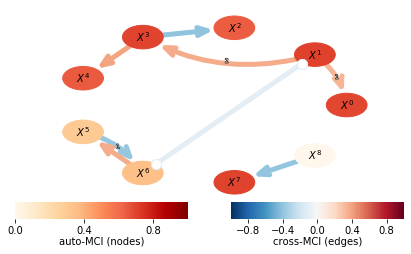

In [16]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
    ); plt.show()

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off.

In the **time series graph**, each entry in ``graph`` can be directly visualized. Directed lagged or contemporaneous links are drawn as arrows and unoriented or conflicting contemporaneous links as straight lines. In each case, the link color refers to the MCI value in ``val_matrix``. Also here, if ``val_matrix`` is not already symmetric for contemporaneous values, the maximum absolute value is shown.

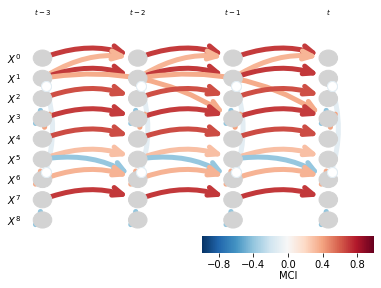

In [17]:
# Plot time series graph
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

Here PCMCIplus correctly estimates the underlying causal graph regarding both the lagged and contemporaneous links and the autodependencies.

The pair $(X^5,X^6)$ depicts a feedback cycle. These often occur in real data and the example shows that time series graphs allow to resolve feedbacks in time while other graph modeling approaches could not represent a cyclic dependency.

The contemporaneously coupled pair $(X^7,X^8)$ illustrates a case where autocorrelation helps to identify the orientation of the link. Without autocorrelation the output of PCMCIplus would be an unoriented link to indicate the Markov equivalence class.

## 4. Comparison with PCMCI and the PC algorithm

In the following we compare PCMCIplus to the standard PCMCI method that only addressed time-lagged causal discovery, and to the PC algorithm (adapted to time series).

Of course, the comparison with **standard PCMCI** on data that actually contains contemporaneous directed dependencies is unfair since this violates an assumption of PCMCI. Let's look at the same toy model example: For PCMCI, we need to construct ``link_matrix`` based on the ``p_matrix`` (thresholded at some ``alpha_level``), which is symmetric for contemporaneous links and, hence, cannot indicate directionality.

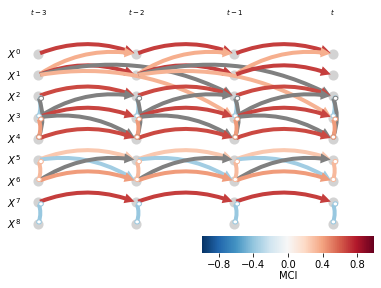

In [13]:
tau_max = 3
alpha_level = 0.001
pcmci.verbosity = 0

results = pcmci.run_pcmci(tau_min=0, tau_max=tau_max, pc_alpha=None)
link_matrix = pcmci.return_significant_links(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=alpha_level)['link_matrix']

# Mark false links as grey 
true_graph = pp.links_to_graph(links=links, tau_max=tau_max)
link_attribute = np.ones(results['val_matrix'].shape, dtype = 'object')
link_attribute[true_graph==0] = 'spurious'
link_attribute[true_graph==1] = ''
# Symmetrize contemp. link attribute
for (i,j) in zip(*np.where(true_graph[:,:,0]==1)):
    link_attribute[i,j,0] = link_attribute[j,i,0] = ''

tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_attribute=link_attribute,
    var_names=var_names,
    )
plt.show()

False positives (grey) here appear due to indirect paths through contemporaneous parents. For example, $X^3_{t-1} \to X^2_t$ appears due to the path $X^3_{t-1} \to X^3_t \to X^4_t$ because PCMCI only removes indirect links and common drivers that come through lagged parents, not those that come through contemporaneous parents. The same holds for the false contemporaneous link $X^2_{t} - X^4_t$ due to $X^2_{t} \leftarrow X^3_t \to X^4_t$. Further, all contemporaneous links remain undirected as indicated by the lines.

The comparison to the **PC algorithm (adapted to time series)** is fair since the underlying assumptions are the same:

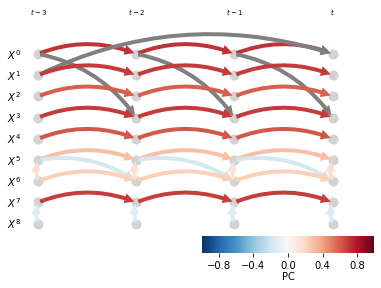

In [14]:
tau_max = 3
pcmci.verbosity = 0

results = pcmci.run_pcalg(tau_min=0, tau_max=tau_max, pc_alpha=0.01)
link_matrix = results['graph']

tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_attribute=link_attribute,
    var_names=var_names,
    link_colorbar_label='PC')
plt.show()

Still the PC algorithm fails here in multiple ways: True links are not detected which then leads to false positives since the previously removed links are not available as conditioning sets anymore. In the paper, the low detection power is identified as the main culprit and this toy example is thoroughly discussed.

Only for very large sample sizes do we get the correct graph. Note the very small ``val_matrix`` since values of a link $X^i_{t-\tau} \to X^j_t$ are determined corresponding to the largest p-value across *any* condition set, and there are a lot.

In [15]:
data_long, nonstationarity_indicator = pp.structural_causal_process(
    links=links, T=100000, noises=noises, seed=seed)
parcorr = ParCorr(significance='analytic')
pcmci_long = PCMCI(
    dataframe=pp.DataFrame(data_long, var_names=var_names), 
    cond_ind_test=parcorr,
    verbosity=1)
tau_max = 3
pcmci_long.verbosity = 0

results = pcmci_long.run_pcalg(tau_min=0, tau_max=tau_max, pc_alpha=0.001)
link_matrix = results['graph']

tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_attribute=link_attribute,
    var_names=var_names,
    link_colorbar_label='PC')
plt.show()

KeyboardInterrupt: 